# Exploratory Data Analysis

**Date**: January 3rd, 2025  
**Description**: The purpose of this notebook is to analyze the images and to familiarize with the data.

The sources from where I will be learning to elaborate this EDA are:

* [EDA for Image Classification](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)

**Sections**
1. Loading data - Functions and classes to load and join data
2. Visualizations - Useful graphs to understand the data
    * Class imbalance
3. Creating a `DataLoader` to train classification Model

In [22]:
import matplotlib.pyplot as plt
from medmnist import INFO
import medmnist
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch


print(medmnist.__version__)

3.0.2


`INFO` can gives us the information for each class. In total, there are 12 classes for each type of medical image that we will use in the kaggle competition, these medmnist datasets are:

**MedMNIST2D Datasets:**
* PathMNIST: Colon pathology images (9 classes)
* ChestMNIST: ~~Chest X-rays (14 labels, multi-label)~~ WE DO NOT USE THIS DATASET
* DermaMNIST: Dermatoscope images (7 classes)
* OCTMNIST: Retinal OCT images (4 classes)
* PneumoniaMNIST: Chest X-rays for pneumonia detection (2 classes)
* RetinaMNIST: Fundus camera images (ordinal regression, 5 classes)
* BreastMNIST: Breast ultrasound images (2 classes)
* BloodMNIST: Blood cell microscope images (8 classes)
* TissueMNIST: Kidney cortex microscope images (8 classes)
* OrganAMNIST: Abdominal CT images (11 classes)
* OrganCMNIST: Abdominal CT images (11 classes)
* OrganSMNIST: Abdominal CT images (11 classes)

For learning purposes, I will be only using and analyzing 2 clases

Total clases:

In [4]:
print(f"There are {len(INFO)} datasets: {INFO.keys()}")

There are 18 datasets: dict_keys(['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d'])


We can extract relevant information about the labels and number of samples.

In [5]:
INFO['pathmnist']

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1',
 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616',
 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?download=1',
 'MD5

## 1. Loading data

In [6]:
# Function to load and extract data
def load_data(dataset_name, label_offset):
    info = INFO[dataset_name]
    DataClass = getattr(medmnist, info['python_class'])
    dataset = DataClass(split='train', download=True)
    return dataset.imgs, dataset.labels + label_offset

In [7]:
# List of dataset names to combine
datasets_to_combine = ['pathmnist', 'dermamnist']  # Add as many datasets as you need

# Initialize combined data arrays
combined_images = []
combined_labels = []

# Variable to track the next label offset
current_label_offset = 0

# Load and combine datasets dynamically
for dataset_name in datasets_to_combine:
    info = INFO[dataset_name]
    num_classes = len(info['label'])  # Number of classes in the dataset
    images, labels = load_data(dataset_name, current_label_offset)
    combined_images.append(images)
    combined_labels.append(labels)
    current_label_offset += num_classes  # Update the offset for the next dataset

# Concatenate all datasets along the first axis
combined_images = np.concatenate(combined_images, axis=0)
combined_labels = np.concatenate(combined_labels, axis=0)

Using downloaded and verified file: /Users/admin/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/admin/.medmnist/dermamnist.npz


In [8]:
class CombinedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [9]:
# Create the combined dataset
combined_dataset = CombinedDataset(combined_images, combined_labels)

In [10]:
print(f"There are {len(combined_dataset)} images to train the model")

There are 97003 images to train the model


## 2. Visualizations

### 2.1 Class imbalance

In [11]:
unique_labels, counts = np.unique(combined_dataset.labels, return_counts=True)
unique_labels, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=uint8),
 array([ 9366,  9509, 10360, 10401,  8006, 12182,  7886,  9401, 12885,
          228,   359,   769,    80,   779,  4693,    99]))

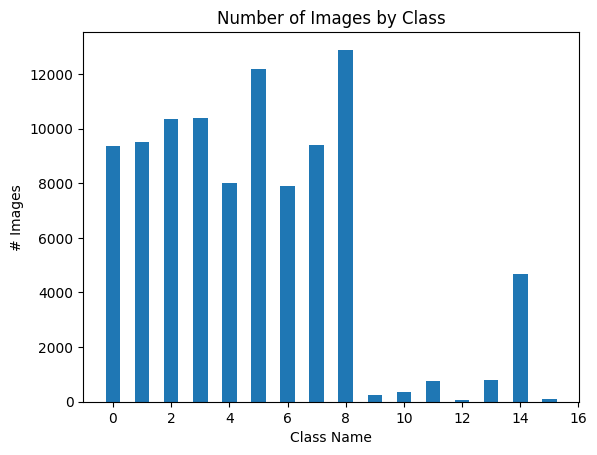

In [12]:
plt.bar(unique_labels, counts, width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.ylabel('# Images')
plt.show();

From labels from 0 to 8 corresponf to `pathmnist`; and from 9 to 15, to `dermamnist`. We can clearly see an imbalance of number of sets for the latter.

### 2.2 Sampling images

Ploting random samples of images

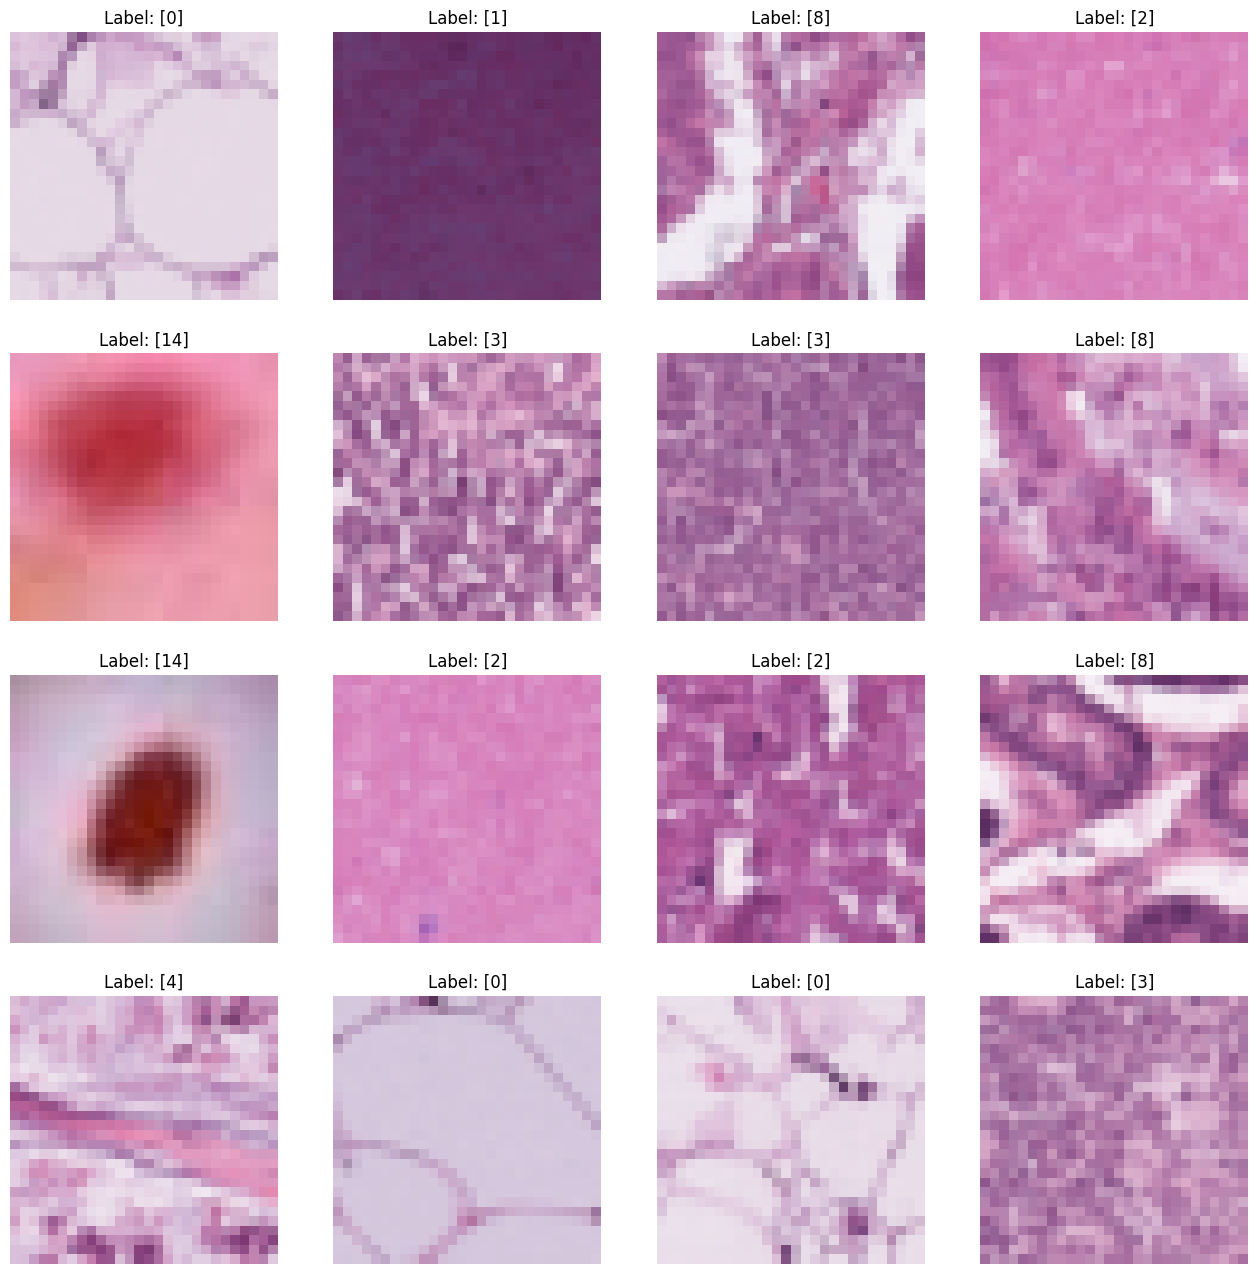

In [25]:
def show_image_sample(ncols: int = 4, nrows: int = 4):
    '''display 4x4 images'''
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        random_idx = random.randint(0, len(combined_dataset))
        img = combined_dataset.images[random_idx]
        label = combined_dataset.labels[random_idx]
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis(False)
    plt.show()
show_image_sample()

## 3. Creating a `DataLoader`

In [13]:
# Example: Create a DataLoader
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Test the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 28, 28, 3]) torch.Size([32, 1])
